In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras import backend
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, Concatenate, Input, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt



data_directory = 'training_data/'
# data_directory = '/Users/dawar/Desktop/AI Lab/x-ray-cluster-masses-23-l3/training_data/'
# data_directory = '/x-ray-cluster-masses-23-l3/code-examples/'
# data_directory = ''

image_file = 'eFEDS_01to18-3dImgs-7946clus-300pix-50pix-ext_det_thr.pickle'
catalog_file = 'eFEDS_mock_clusters_catalog_01to18-ext_det_thr.f'

def get_data(image_p, catalog_f):
    '''
    Given the image and catalogue path, this function returns the
    images and labels needed to start directly with model training.
    train_labels: Can be used to filter a particular mass range
    Returns:
    images: [index, energy-band-image]
    labels_z: [log10(mass), redshift, index]
    '''
    is_efedssim=True
    is_efedsobs=False
    images = pd.read_pickle(image_p)
    key_mass = 'm500_wl_final' if is_efedsobs else 'M500c' if is_efedssim else 'HALO_M500c'
    key_redshift = 'z_final' if is_efedsobs else 'z' if is_efedssim else 'redshift_R'
    catalog_df = pd.read_feather(catalog_f)
    labels = np.log10(catalog_df[key_mass])
    redshifts = catalog_df[key_redshift].values
    indices = catalog_df.index.values
    labels_z = np.transpose([labels, redshifts, indices])
    return images, labels_z

images, labels_z = get_data(image_p=data_directory+image_file, catalog_f=data_directory+catalog_file)
print(len(images))
print(len(labels_z))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2
7946
Num GPUs Available:  1


In [2]:

# Get mass and redshift values from the labels_z array
masses = labels_z[:,0]
redshifts = labels_z[:,1]

In [3]:

# Split the data into training, validation, and test sets
# The random state ensures that the split is reproducible
X_train, X_test, y_train, y_test = train_test_split(images['gsm_3dImgs'], np.stack((masses, redshifts), axis=1), test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)


# Print the shapes of the resulting sets
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Train set: (5084, 50, 50, 10), (5084, 2)
Validation set: (1272, 50, 50, 10), (1272, 2)
Test set: (1590, 50, 50, 10), (1590, 2)


In [4]:
def log_gauss_error(y_true, y_pred):

    ''' Cost function as the negative log-likelihood '''
    
    y_pred_0 = y_pred[:, 0]
    y_pred_1 = y_pred[:, 1]

    y_pred_0 = tf.convert_to_tensor(y_pred_0)
    y_pred_1 = tf.convert_to_tensor(y_pred_1)
    y_true = tf.cast(y_true, y_pred.dtype)

    error = 0.5 * tf.math.squared_difference(y_pred_0, y_true)
    error += 0.5 * tf.math.log(2 * tf.constant(np.pi) * y_pred_1 ** 2)
    return tf.reduce_mean(error, axis=-1)



In [5]:


# Define the model

early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min', restore_best_weights=True)
model = Sequential()
## Data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
])
model.add(Conv2D(10, (3, 3), activation='relu', input_shape=(50, 50, 10)))  # Updated input shape
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(30, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(40, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))


# Concatenate the redshift information
redshift_input = Input(shape=(1,))
concatenated = Concatenate()([model.output, redshift_input])

# Add a final output layer for regression
output = Dense(1, activation='linear')(concatenated)

# Create the model
model = Model(inputs=[model.input, redshift_input], outputs=output)

# Define the optimizer
optimizer = Adam()

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')


# Print the model summary
model.summary()

Metal device set to: Apple M1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 50, 50, 10)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 10)   910         ['conv2d_input[0][0]']           
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 24, 10)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 22, 22, 20)   1820        ['max_pooling2d[0][0]']      

In [6]:

# Apply data augmentation to the training data
X_train_augmented = data_augmentation(X_train)


# Train the model with augmented data
history = model.fit([X_train_augmented, y_train[:, 1]], y_train[:, 0], 
                    validation_data=([X_val, y_val[:, 1]], y_val[:, 0]), 
                    epochs=300, batch_size=64, callbacks=[early_stopping])

Epoch 1/300


2023-05-26 15:23:51.171725: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


80/80 [==============================] - 3s 35ms/step - loss: 48.3024 - val_loss: 3.4821
Epoch 2/300
80/80 [==============================] - 1s 19ms/step - loss: 1.3333 - val_loss: 0.7526
Epoch 3/300
80/80 [==============================] - 1s 17ms/step - loss: 0.4511 - val_loss: 0.4021
Epoch 4/300
80/80 [==============================] - 1s 17ms/step - loss: 0.2816 - val_loss: 0.5049
Epoch 5/300
80/80 [==============================] - 1s 16ms/step - loss: 0.2295 - val_loss: 0.3798
Epoch 6/300
80/80 [==============================] - 1s 17ms/step - loss: 0.2008 - val_loss: 0.3721
Epoch 7/300
80/80 [==============================] - 1s 16ms/step - loss: 0.2029 - val_loss: 0.3699
Epoch 8/300
80/80 [==============================] - 1s 17ms/step - loss: 0.1988 - val_loss: 0.3110
Epoch 9/300
80/80 [==============================] - 1s 17ms/step - loss: 0.1791 - val_loss: 0.2900
Epoch 10/300
80/80 [==============================] - 1s 16ms/step - loss: 0.1885 - val_loss: 0.2375
Epoch 11/3

In [7]:
model.save('our_best_CNN.h5')

In [ ]:
# Plot training and validation loss
val_loss = history.history['val_loss']
train_loss = history.history['loss']


plt.plot(np.log(train_loss), label='Training Loss')
plt.plot(np.log(val_loss), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Log of validation loss')
plt.ylim(-3.5,0)
plt.legend()
plt.savefig('best_CNN_loss.png')
plt.show()

50/50 [==============================] - 0s 5ms/step


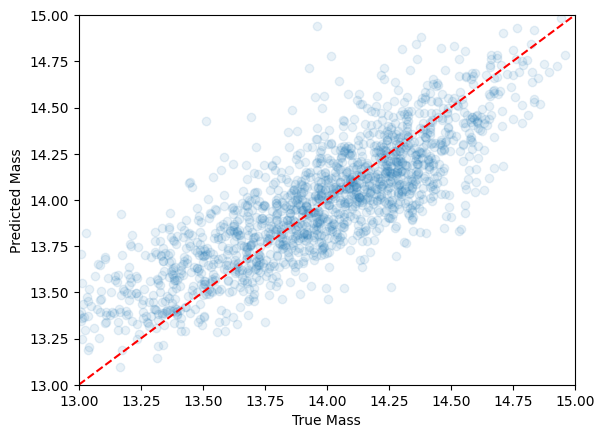

In [10]:
# Get predictions on test set and calculate scatter
model = load_model('our_best_CNN.h5')

y_pred = model.predict([X_test, y_test[:, 1]])
plt.scatter(y_test[:, 0], y_pred, alpha=0.1)
plt.plot([13, 15], [13, 15], 'r--')
plt.xlim(13, 15)
plt.ylim(13, 15)
plt.xlabel('True Mass')
plt.ylabel('Predicted Mass')
plt.savefig('predictions_best_CNN.png', dpi=300)
plt.show()

In [11]:
# Get mass and redshift values from the labels_z array
masses = labels_z[:,0]
redshifts = labels_z[:,1]

# Split the data into training, validation, and test sets
# The random state ensures that the split is reproducible
X_train, X_test, y_train, y_test = train_test_split(images['gsm_3dImgs'], np.stack((masses, redshifts), axis=1), test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)


data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
])

X_train_augmented = data_augmentation(X_train)


In [12]:
model = load_model('our_best_CNN.h5')

model.layers.pop()

for layer in model.layers:
    layer.trainable = False
    
redshift_input = Input(shape=(1,))
#concatenated = Concatenate()([model.output, redshift_input])

# Add a final output layer for regression
output = Dense(2, activation='linear')(model.output)
model = Model(inputs=[model.input, redshift_input], outputs=output)

model.compile(optimizer=Adam(), loss=log_gauss_error)

# Train the model with augmented data
history = model.fit([X_train_augmented, y_train[:, 1]], y_train[:, 0], 
                    validation_data=([X_val, y_val[:, 1]], y_val[:, 0]), 
                    epochs=200, batch_size=64, callbacks=[early_stopping])

Epoch 1/200
80/80 [==============================] - 3s 28ms/step - loss: 130.8385 - val_loss: 121.8295
Epoch 2/200
80/80 [==============================] - 1s 13ms/step - loss: 112.8307 - val_loss: 104.7110
Epoch 3/200
80/80 [==============================] - 1s 12ms/step - loss: 96.7309 - val_loss: 89.4429
Epoch 4/200
80/80 [==============================] - 1s 12ms/step - loss: 82.3806 - val_loss: 75.8391
Epoch 5/200
80/80 [==============================] - 1s 12ms/step - loss: 69.5657 - val_loss: 63.6265
Epoch 6/200
80/80 [==============================] - 1s 13ms/step - loss: 57.4396 - val_loss: 49.0397
Epoch 7/200
80/80 [==============================] - 1s 12ms/step - loss: 45.9443 - val_loss: 42.2025
Epoch 8/200
80/80 [==============================] - 1s 12ms/step - loss: 38.2945 - val_loss: 34.5171
Epoch 9/200
80/80 [==============================] - 1s 12ms/step - loss: 31.1897 - val_loss: 27.9270
Epoch 10/200
80/80 [==============================] - 1s 13ms/step - loss: 25.

50/50 [==============================] - 0s 5ms/step


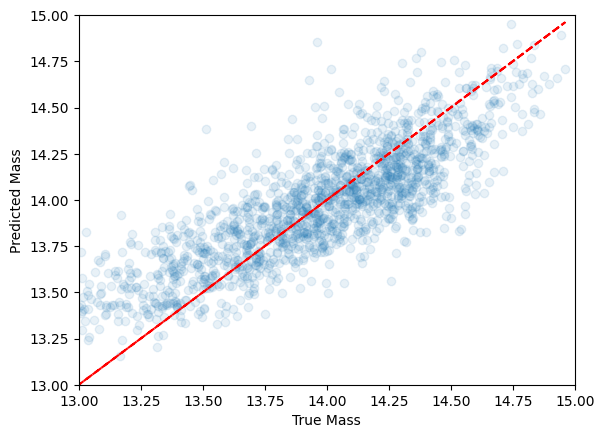

In [13]:
# Get predictions on test set
y_pred = model.predict([X_test, y_test[:, 1]])
plt.scatter(y_test[:, 0], y_pred[:,0], alpha=0.1)
plt.plot(y_test[:, 0], y_test[:, 0], 'r--')
plt.xlabel('True Mass')
plt.ylabel('Predicted Mass')
plt.xlim(13, 15)
plt.ylim(13, 15)
plt.savefig('predictions_best_CNN_variance.png', dpi=300)
plt.show()

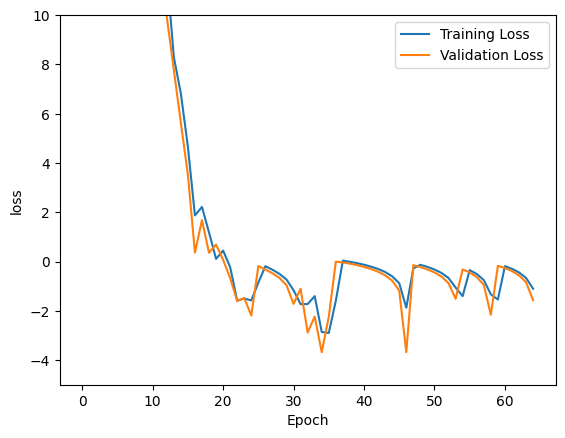

In [20]:
val_loss = history.history['val_loss']
train_loss = history.history['loss']
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim(-5,10)
plt.legend()
plt.savefig('best_CNN_loss_variance.png')
plt.show()


/var/folders/tp/tnhr6z_91zlcvt52m6dnhggh0000gn/T/ipykernel_10076/958514029.py:3: RuntimeWarning: invalid value encountered in log
  plt.scatter(y_test[:, 0], np.log(y_pred[:,1]), alpha=0.1)


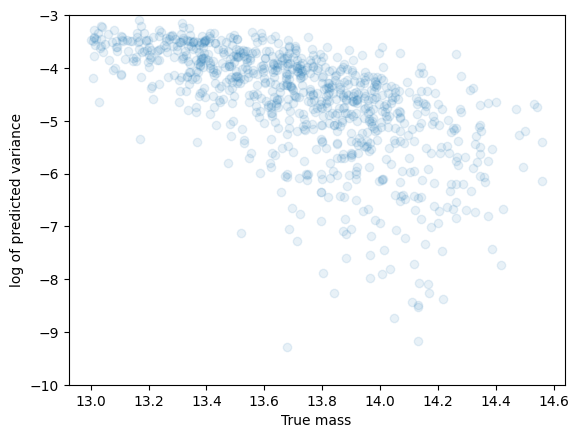

In [19]:
#plotting the predicted variances in our predictions 

plt.scatter(y_test[:, 0], np.log(y_pred[:,1]), alpha=0.1)
plt.xlabel('True mass')
plt.ylabel('log of predicted variance')
plt.ylim(-10, -3)
plt.savefig('best_CNN_variance.png', dpi=300)



In [16]:
model.save('our_best_CNN_variance.h5')

In [20]:
y_pred[:,0]/y_pred[:,1]

array([  896.16583,  2006.8907 ,  2912.8948 , ..., 23437.873  ,
         718.7838 ,  1146.5948 ], dtype=float32)